In [4]:
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [22]:
# project root
project_root = Path.cwd()

# data directories
train_dir = project_root / "data" / "train_files"
supplemental_dir = project_root / "data" / "supplemental_files"

# results directory
results_dir = project_root / "results"

In [6]:
# load the data

stock_prices = pd.read_csv(train_dir / "stock_prices.csv")
secondary_stock_prices = pd.read_csv(train_dir / "secondary_stock_prices.csv")
stock_prices_supplemental = pd.read_csv(supplemental_dir / "stock_prices_supplemental.csv")
secondary_stock_prices_supplemental = pd.read_csv(supplemental_dir / "secondary_stock_prices_supplemental.csv")

In [7]:
stock_prices_all = pd.concat(
    [
        stock_prices,
        secondary_stock_prices,
        stock_prices_supplemental,
        secondary_stock_prices_supplemental
    ],
    ignore_index=True
)

stock_prices_all.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [8]:
df = stock_prices_all.copy()
df = df.drop(columns=["RowId"], errors="ignore")
df = df.drop(columns=["AdjustmentFactor"], errors="ignore")
df["Date"] = pd.to_datetime(df["Date"])
df["SecuritiesCode"] = df["SecuritiesCode"].astype(int)
df["SupervisionFlag"] = df["SupervisionFlag"].astype(int)
df["ExpectedDividend"] = df["ExpectedDividend"].fillna(0)
df = df.dropna(subset=["Target"]).copy()
print(df.dtypes)
df.head()

Date                datetime64[ns]
SecuritiesCode               int64
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                       int64
ExpectedDividend           float64
SupervisionFlag              int64
Target                     float64
dtype: object


,Date,SecuritiesCode,Open,High,Low,Close,Volume,ExpectedDividend,SupervisionFlag,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.0,0,0.000730
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,0.0,0,0.012324
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,0.0,0,0.006154
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,0.0,0,0.011053
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,0.0,0,0.003026


In [9]:
df = df.sort_values(["SecuritiesCode", "Date"]).reset_index(drop=True)
ohlc = ["Open", "High", "Low", "Close"]

df[ohlc] = (
    df.groupby("SecuritiesCode")[ohlc]
      .apply(lambda g: g.interpolate().ffill().bfill())
      .reset_index(level = 0, drop=True)
)

df[ohlc].isna().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

In [10]:
df["Daily_Range"] = df["Close"] - df["Open"]
df["Mean"] = (df["High"] + df["Low"]) / 2
df.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,ExpectedDividend,SupervisionFlag,Target,Daily_Range,Mean
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.0,0,0.000730,8.0,2742.5
1,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,0.0,0,0.002920,-5.0,2741.0
2,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,0.0,0,-0.001092,6.0,2732.0
3,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,0.0,0,-0.005100,3.0,2744.5
4,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,0.0,0,-0.003295,-3.0,2744.5


In [11]:
split_date = df["Date"].quantile(0.8)
print("Split date:",split_date)

Split date: 2021-06-07 00:00:00


In [12]:
train_df = df[df["Date"] < split_date].copy()
test_df  = df[df["Date"] >= split_date].copy()

print("Train rows:", len(train_df))
print("Test rows:", len(test_df))

Train rows: 4215021
Test rows: 1055503


In [13]:
exclude = ["Date", "Target", "SecuritiesCode","SupervisionFlag"]

X_train = train_df.drop(columns = exclude)
y_train = train_df["Target"]

X_test  = test_df.drop(columns = exclude)
y_test  = test_df["Target"]

In [14]:
scale_cols = ["Open", "High", "Low", "Close", "Volume", "Daily_Range", "Mean", "ExpectedDividend"]

train_mean = X_train[scale_cols].mean()
train_std  = X_train[scale_cols].std()

X_train[scale_cols] = (X_train[scale_cols] - train_mean) / train_std
X_test[scale_cols]  = (X_test[scale_cols]  - train_mean) / train_std

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
y_pred = model.predict(X_test)

In [18]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2:", r2)
print("RMSE:", rmse)

R^2: -0.0005511706184975207
RMSE: 0.024918085986315813


In [19]:
def evaluate(features):
    Xtr = X_train[features]
    Xte = X_test[features]
    m = LinearRegression()
    m.fit(Xtr, y_train)
    y_hat = m.predict(Xte)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    r2 = r2_score(y_test, y_hat)
    print("Features:", features)
    print("RMSE:", rmse, " R²:", r2)

Feature Coefficients:
            Feature  Coefficient  Abs_Coefficient
3             Close    -0.014750         0.014750
0              Open    -0.014748         0.014748
1              High     0.010976         0.010976
7              Mean     0.009835         0.009835
2               Low     0.008674         0.008674
5  ExpectedDividend    -0.000248         0.000248
6       Daily_Range    -0.000231         0.000231
4            Volume    -0.000067         0.000067


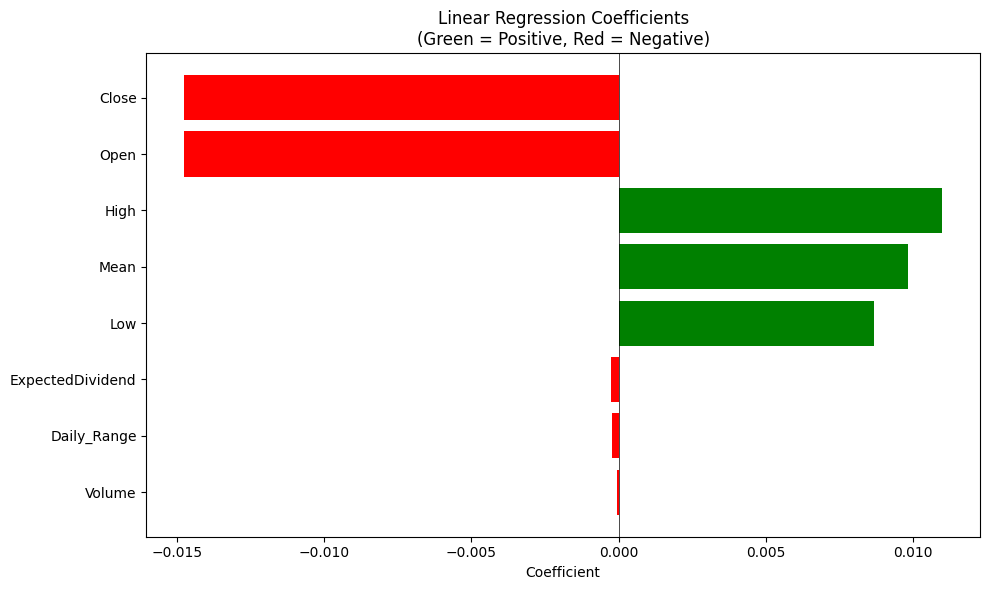

In [23]:
import matplotlib.pyplot as plt

feature_names = X_train.columns.tolist()
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("Feature Coefficients:")
print(coefficients)

plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in coefficients['Coefficient']]
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Linear Regression Coefficients\n(Green = Positive, Red = Negative)')
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
save_path = results_dir / "linear_regression_coefficients.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

In [25]:
def calculate_sharpe_ratio(test_df, predictions, portfolio_size=200, toprank_weight_ratio=2):
    """
    JPX Competition Sharpe Ratio with weighted returns.
    """
    df_eval = test_df.copy()
    df_eval['Prediction'] = predictions

    daily_spread_returns = []

    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)

    for date in df_eval['Date'].unique():
        day_data = df_eval[df_eval['Date'] == date].copy()

        if len(day_data) >= portfolio_size * 2:
            day_data['Rank'] = day_data['Prediction'].rank(ascending=False) - 1
            day_data = day_data.sort_values('Rank')

            top_returns = day_data.head(portfolio_size)['Target'].values
            purchase = (top_returns * weights).sum() / weights.sum()

            bottom_returns = day_data.tail(portfolio_size)['Target'].values[::-1]
            short = (bottom_returns * weights).sum() / weights.sum()

            spread_return = purchase - short
            daily_spread_returns.append(spread_return)

    daily_spread_returns = np.array(daily_spread_returns)

    if len(daily_spread_returns) > 0 and daily_spread_returns.std() > 0:
        sharpe = daily_spread_returns.mean() / daily_spread_returns.std()
    else:
        sharpe = 0

    return sharpe, daily_spread_returns

sharpe, spread_returns = calculate_sharpe_ratio(test_df, y_pred)

print("JPX Sharpe Ratio:", sharpe)
print("Mean daily spread:", spread_returns.mean())
print("Std daily spread:", spread_returns.std())
print("Days evaluated:", len(spread_returns))


sharpe_summary = pd.DataFrame({
    "metric": [
        "jpx_sharpe_ratio",
        "mean_daily_spread",
        "std_daily_spread",
        "days_evaluated"
    ],
    "value": [
        sharpe,
        spread_returns.mean(),
        spread_returns.std(),
        len(spread_returns)
    ]
})
save_path = results_dir / "linear_regression_sharpe_metrics.csv"
sharpe_summary.to_csv(save_path, index=False)

JPX Sharpe Ratio: 0.004288817306640533
Mean daily spread: 3.486238184568288e-05
Std daily spread: 0.008128670296052055
Days evaluated: 258


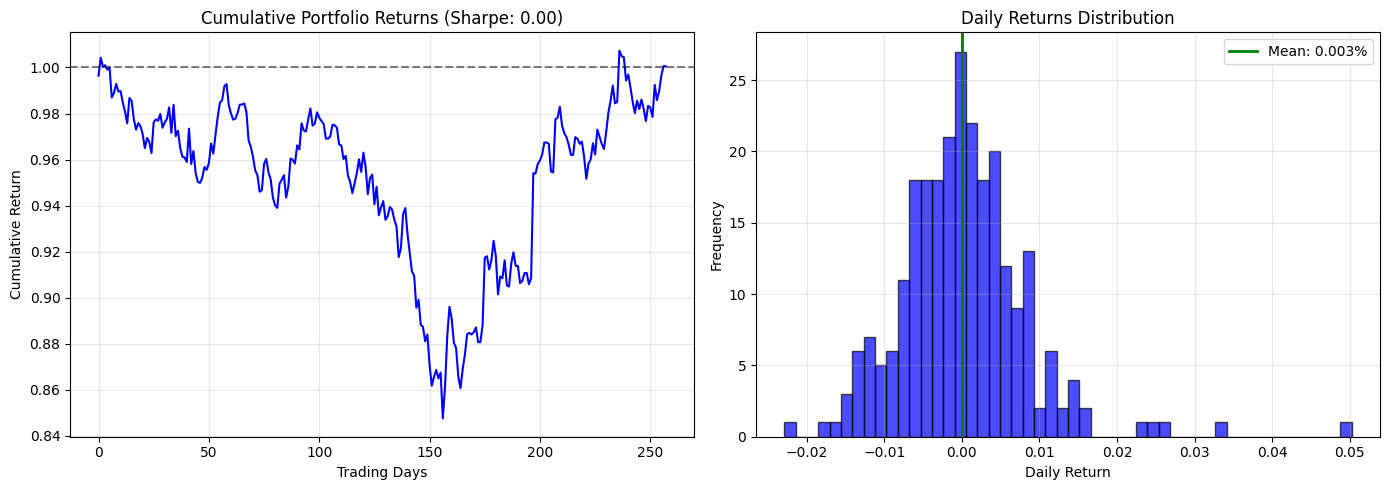

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
cumulative = (1 + pd.Series(spread_returns)).cumprod()
ax1.plot(cumulative, color='blue', linewidth=1.5)
ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax1.set_title(f'Cumulative Portfolio Returns (Sharpe: {sharpe:.2f})')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.hist(spread_returns, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax2.axvline(x=np.mean(spread_returns), color='green', linestyle='-', linewidth=2,
            label=f'Mean: {np.mean(spread_returns)*100:.3f}%')
ax2.set_title('Daily Returns Distribution')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
save_path = results_dir / "linear_regression_sharpe_plots.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()